In [ ]:
!pip install Catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc
from math import floor, ceil

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, f1_score, roc_auc_score,  r2_score, mean_absolute_error,mean_squared_error, recall_score, precision_score


from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix
from sklearn.ensemble import AdaBoostRegressor

from prophet import Prophet


In [ ]:
df = pd.read_csv('traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
df["DateTime"] = pd.to_datetime(df['DateTime'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['day_of_month'] = df['DateTime'].dt.day
#df['Hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['Date']= df['DateTime'].dt.date
df['Time']= df['DateTime'].dt.hour
df['Quarter']=  df['DateTime'].dt.quarter


df['day_of_year']=  df['DateTime'].dt.dayofyear
df['Seconds'] = pd.to_timedelta(df['DateTime'].dt.strftime('%H:%M:%S')).dt.total_seconds().astype(int)

In [ ]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Seconds
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,6,2015-11-01,0,4,305,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6,2015-11-01,1,4,305,3600
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,6,2015-11-01,2,4,305,7200
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,6,2015-11-01,3,4,305,10800
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,6,2015-11-01,4,4,305,14400


In [ ]:
#Encoding the Date Column
encoder =LabelEncoder()
df['Date'] = encoder.fit_transform(df['Date'])
import pickle
output = open('Labelencoder.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

In [ ]:
df1 = df.copy()
df['DateTime'] = pd.to_datetime(df['DateTime'])
# Converting the DateTime Column into integer
df['DateTime'] = df['DateTime'].values.astype(np.int64) / 10 ** 9

### cross validation

In [ ]:
def cross_validation(X, y, model, splits=10, seed=42):
  tscv = TimeSeriesSplit(n_splits=splits)
  RMSE_scores = []  # List to store RMSE scores
  MAPE_scores = []  # List to store MAPE scores
  MAE_scores = []   # List to store MAE scores
  predictions = []  # List to store predictions per split
  model =  model     # Initialize the model

  i = 0
  for train, test in tscv.split(X):
      x_train, x_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
      model.fit(x_train, y_train)
      RMSE = mean_squared_error(y_test, model.predict(x_test), squared=False)
      MAPE = mean_absolute_percentage_error(y_test, model.predict(x_test)) * 100
      MAE = mean_absolute_error(y_test, model.predict(x_test))

      print(f'Splits Trained: {i} \t RMSE:  {RMSE}  \t MAPE: {MAPE}  \t MAE: {MAE}')
      RMSE_scores.append(RMSE)
      MAPE_scores.append(MAPE)
      MAE_scores.append(MAE)
      i += 1

  # Calculate the mean of validation scores
  print('Average RMSE: ', np.mean(RMSE_scores))
  print('Average MAPE: ', np.mean(MAPE_scores))
  print('Average MAE: ', np.mean(MAE_scores))

  return predictions


In [ ]:
#Use Target Encoding to create new features  with aggregates : Std, Max,Min, Mean and Median
def generate_encoded_features(dataframe):
    selected_features = ['Month', 'Quarter', 'day_of_month', 'day_of_week', 'Time', 'day_of_year']
    for feature in tqdm(selected_features):
    # Aggregate vehicles by selected feature
      aggregate_data = dataframe.groupby(feature)['Vehicles'].agg(['std', 'max', 'min', 'mean', 'median'])
      # Rename columns
      aggregate_data.columns = [feature + '_' + c + '_vehicles' for c in aggregate_data.columns]
      # Convert data types
      aggregate_data = aggregate_data.astype({c: np.float32 for c in aggregate_data.columns})
      # Reset index
      aggregate_data.reset_index(inplace=True)
      # Merge aggregated data with the original dataframe
      dataframe = dataframe.merge(aggregate_data, on=feature, how='left')
      gc.collect()
    return dataframe

df2 = generate_encoded_features(df)

100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


In [ ]:
df2.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Year', 'Month',
       'day_of_month', 'day_of_week', 'Date', 'Time', 'Quarter', 'day_of_year',
       'Seconds', 'Month_std_vehicles', 'Month_max_vehicles',
       'Month_min_vehicles', 'Month_mean_vehicles', 'Month_median_vehicles',
       'Quarter_std_vehicles', 'Quarter_max_vehicles', 'Quarter_min_vehicles',
       'Quarter_mean_vehicles', 'Quarter_median_vehicles',
       'day_of_month_std_vehicles', 'day_of_month_max_vehicles',
       'day_of_month_min_vehicles', 'day_of_month_mean_vehicles',
       'day_of_month_median_vehicles', 'day_of_week_std_vehicles',
       'day_of_week_max_vehicles', 'day_of_week_min_vehicles',
       'day_of_week_mean_vehicles', 'day_of_week_median_vehicles',
       'Time_std_vehicles', 'Time_max_vehicles', 'Time_min_vehicles',
       'Time_mean_vehicles', 'Time_median_vehicles',
       'day_of_year_std_vehicles', 'day_of_year_max_vehicles',
       'day_of_year_min_vehicles', 'day_of_year_mean_vehicles',

In [ ]:
len(df2)

48120

In [ ]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Seconds
0,1.446336e+09,1,15,20151101001,2015,11,1,6,0,0,4,305,0
1,1.446340e+09,1,13,20151101011,2015,11,1,6,0,1,4,305,3600
2,1.446343e+09,1,10,20151101021,2015,11,1,6,0,2,4,305,7200
3,1.446347e+09,1,7,20151101031,2015,11,1,6,0,3,4,305,10800
4,1.446350e+09,1,9,20151101041,2015,11,1,6,0,4,4,305,14400


In [ ]:
df_junction1= df2.loc[df2['Junction']==1]
df_junction2= df2.loc[df2['Junction']==2]
df_junction3= df2.loc[df2['Junction']==3]
df_junction4= df2.loc[df2['Junction']==4]

df_junction1.reset_index(inplace=True, drop=True)
df_junction2.reset_index(inplace=True, drop=True)
df_junction3.reset_index(inplace=True, drop=True)
df_junction4.reset_index(inplace=True, drop=True)

## Junction1 Model

In [ ]:
#Declaring Input and Output Variables
X = df_junction1.drop(['Vehicles','Seconds', 'ID', 'Junction'], axis=1)
y = df_junction1['Vehicles']

In [ ]:
# X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')

In [ ]:
a= ceil(0.8 * len(df_junction1))
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]

X_valid.head()

,DateTime,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Month_std_vehicles,...,Time_std_vehicles,Time_max_vehicles,Time_min_vehicles,Time_mean_vehicles,Time_median_vehicles,day_of_year_std_vehicles,day_of_year_max_vehicles,day_of_year_min_vehicles,day_of_year_mean_vehicles,day_of_year_median_vehicles
11674,1.488362e+09,2017,3,1,2,486,10,1,60,20.499683,...,20.842903,107.0,1.0,24.229925,15.0,22.523212,98.0,2.0,27.351191,21.0
11675,1.488366e+09,2017,3,1,2,486,11,1,60,20.499683,...,24.142347,136.0,1.0,27.495262,17.0,22.523212,98.0,2.0,27.351191,21.0
11676,1.488370e+09,2017,3,1,2,486,12,1,60,20.499683,...,24.568724,129.0,2.0,28.403990,18.0,22.523212,98.0,2.0,27.351191,21.0
11677,1.488373e+09,2017,3,1,2,486,13,1,60,20.499683,...,21.684610,118.0,2.0,25.588530,17.0,22.523212,98.0,2.0,27.351191,21.0
11678,1.488377e+09,2017,3,1,2,486,14,1,60,20.499683,...,23.902777,162.0,1.0,27.702744,19.0,22.523212,98.0,2.0,27.351191,21.0


In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
#LinearRegression
lg =  LinearRegression()
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_valid)
lg_RMSE = mean_squared_error(y_valid,lg_pred, squared=False)
lg_MAPE= mean_absolute_percentage_error(y_valid,lg_pred)*100

print("LinearRegression RMSE score on validation set is : ",lg_RMSE)
print("LinearRegression MAPE score on validation set is : ",lg_MAPE, '%')

print('--------'*20)

#LassoRegression
l =  Lasso()
l.fit(X_train, y_train)
l_pred = l.predict(X_valid)
l_RMSE = mean_squared_error(y_valid,l_pred, squared=False)
l_MAPE= mean_absolute_percentage_error(y_valid,l_pred)*100

print("LassoRegression RMSE score on validation set is : ",l_RMSE)
print("LassoRegression MAPE score on validation set is : ",l_MAPE, '%')

print('--------'*20)

#RidgeRegression
rr =  Ridge()
rr.fit(X_train, y_train)
rr_pred = rr.predict(X_valid)
rr_RMSE = mean_squared_error(y_valid,rr_pred, squared=False)
rr_MAPE= mean_absolute_percentage_error(y_valid,rr_pred)*100

print("RidgeRegression RMSE score on validation set is : ",rr_RMSE)
print("RidgeRegression MAPE score on validation set is : ",rr_MAPE, '%')

print('--------'*20)


# Catboost
cat = CatBoostRegressor(verbose=False, iterations=100)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_RMSE = mean_squared_error(y_valid,cat_pred, squared=False)
cat_MAPE= mean_absolute_percentage_error(y_valid,cat_pred)*100

print("CatBoost RMSE score on validation set is : ",cat_RMSE)
print("CatBoost MAPE score on validation set is : ",cat_MAPE, '%')

print('--------'*20)

lgb = LGBMRegressor()#num_iterations=1000)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100

print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

# print('--------'*20)

# XGBoost
xg = XGBRegressor()#n_estimators=1000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
xg_RMSE = mean_squared_error(y_valid,xg_pred, squared=False)
xg_MAPE= mean_absolute_percentage_error(y_valid,xg_pred)*100

print("XGBoost RMSE score on validation set is : ",xg_RMSE)
print("XGBoost MAPE score on validation set is : ",xg_MAPE, '%')

print('--------'*20)


#AdaBoost
ab =  AdaBoostRegressor()
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_valid)
ab_RMSE = mean_squared_error(y_valid,ab_pred, squared=False)
ab_MAPE= mean_absolute_percentage_error(y_valid,ab_pred)*100

print("AdaBoost RMSE score on validation set is : ",ab_RMSE)
print("AdaBoost MAPE score on validation set is : ",ab_MAPE, '%')

print('--------'*20)



#Naive Bayes
nb =  GradientBoostingRegressor()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_valid)
nb_RMSE = mean_squared_error(y_valid,nb_pred, squared=False)
nb_MAPE= mean_absolute_percentage_error(y_valid,nb_pred)*100

print("Gradient Boosting RMSE score on validation set is : ",nb_RMSE)
print("Gradient Boosting MAPE score on validation set is : ",nb_MAPE, '%')

print('--------'*20)

#DecisionTree
dt =  DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
dt_RMSE = mean_squared_error(y_valid,dt_pred, squared=False)
dt_MAPE= mean_absolute_percentage_error(y_valid,dt_pred)*100

print("DecisionTree RMSE score on validation set is : ",dt_RMSE)
print("DecisionTree MAPE score on validation set is : ",dt_MAPE, '%')

print('--------'*20)

#RandomForest
rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
rf_MAPE= mean_absolute_percentage_error(y_valid,rf_pred)*100

print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print("RandomForest MAPE score on validation set is : ",rf_MAPE, '%')

print('--------'*20)



#SVC
svc =  SVR()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_valid)
svc_RMSE = mean_squared_error(y_valid,svc_pred, squared=False)
svc_MAPE= mean_absolute_percentage_error(y_valid,svc_pred)*100

print("SVC RMSE score on validation set is : ",svc_RMSE)
print("SVC MAPE score on validation set is : ",svc_MAPE, '%')

print('--------'*20)

#LinearSVC
lsvc =  LinearSVR()
lsvc.fit(X_train, y_train)
lsvc_pred = lsvc.predict(X_valid)
lsvc_RMSE = mean_squared_error(y_valid,lsvc_pred, squared=False)
lsvc_MAPE= mean_absolute_percentage_error(y_valid,lsvc_pred)*100
print("LinearSVC RMSE score on validation set is : ",lsvc_RMSE)
print("LinearSVC MAPE score on validation set is : ",lsvc_MAPE, '%')

print('--------'*20)

LinearRegression RMSE score on validation set is :  12.854839685236444
LinearRegression MAPE score on validation set is :  15.230172440499725 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LassoRegression RMSE score on validation set is :  12.790992639284461
LassoRegression MAPE score on validation set is :  17.67307387938472 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RidgeRegression RMSE score on validation set is :  12.695813291489005
RidgeRegression MAPE score on validation set is :  15.475676546095835 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost RMSE score on validation set is :  17.109869105557205
CatBoost MAPE score on vali

### Prophet model1

In [ ]:
a= ceil(0.8 * len(df_junction1))
a
train=df_junction1.iloc[:a]
test=df_junction1.iloc[a:]

train['DateTime'] =list(df1.loc[df1['Junction']==1]['DateTime'].iloc[:a])
test['DateTime'] =list(df1.loc[df1['Junction']==1]['DateTime'].iloc[a:])
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

train.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
test.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
train = train.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})
test = test.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [ ]:
# train['ds'] = train['ds'].dt.tz_localize(None)
# test['ds'] = test['ds'].dt.tz_localize(None)

model = Prophet(yearly_seasonality=True)
for col in train.columns:
    if col != 'y' and col != 'ds':
        model.add_regressor(col)
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwpey9fx8/rw86mxgc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwpey9fx8/a149lk4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10756', 'data', 'file=/tmp/tmpwpey9fx8/rw86mxgc.json', 'init=/tmp/tmpwpey9fx8/a149lk4s.json', 'output', 'file=/tmp/tmpwpey9fx8/prophet_modeli59khavu/prophet_model-20240325213905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# making predictions for the next 10 months
X_test = test.drop('y', axis=1)
y_test= test['y']

forecast = model.predict(X_test)
pred = forecast['yhat']
forecast[[ 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper' ]].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-03-01 10:00:00,72.918473,64.125452,80.996707,87.409781,87.409781,87.409781
1,2017-03-01 11:00:00,78.975411,70.610538,86.731996,87.415175,87.415175,87.415175
2,2017-03-01 12:00:00,80.010632,71.397632,88.504209,87.420568,87.420568,87.420568
3,2017-03-01 13:00:00,74.166980,65.676550,82.760836,87.425962,87.425962,87.425962
4,2017-03-01 14:00:00,77.674080,68.841653,86.521372,87.431355,87.431355,87.431355


In [ ]:
prof_MAPE= mean_absolute_percentage_error(y_test,pred)*100
print("Prophet Model MAPE score on validation set is : {:.2f} ".format(prof_MAPE))

Prophet Model MAPE score on validation set is : 14.27 


In [ ]:
prof_RMSE= mean_squared_error(y_test,pred, squared=False)
print("Prophet Model RMSE score on validation set is : {:.2f} ".format(prof_RMSE))

Prophet Model RMSE score on validation set is : 13.21 


# ARIMAX model

In [ ]:
df_junction1 = df_junction1.drop(['Seconds', 'ID', 'Junction'], axis=1)
df_junction1['DateTime'] =list(df1.loc[df1['Junction']==1]['DateTime'])

In [ ]:
train=df_junction1.iloc[:a]
test=df_junction1.iloc[a:]
train.set_index('DateTime', inplace=True, drop=True)
test.set_index('DateTime', inplace=True, drop=True)

In [ ]:
c= []

for col in train.columns:
    if col != 'Vehicles':
        c.append(col)

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(train['Vehicles'], exogenous = train[c], trace=True,
                          suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=43.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73801.230, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73405.562, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73476.352, Time=3.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73799.235, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73281.894, Time=1.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73239.872, Time=2.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=73225.318, Time=4.98 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=73116.258, Time=7.53 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=71801.080, Time=34.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=73216.744, Time=13.58 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=71776.836, Time=65.03 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=53.46 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=72.20 sec
 ARIMA(4,1,3)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11674
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -35879.485
Date:                Mon, 25 Mar 2024   AIC                          71774.970
Time:                        21:48:51   BIC                          71833.890
Sample:                    11-01-2015   HQIC                         71794.762
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1889      0.042     28.479      0.000       1.107       1.271
ar.L2         -0.2288      0.045     -5.133      0.000      -0.316      -0.141
ar.L3       6.647e-05      0.012      0.006      0.996      -0.023       0.024
ar.L4          0.0182      0.013      1.414      0.157      -0.007       0.044
ar.L5         -0.1555      0.011    -13.960      0.000      -0.177      -0.134
ma.L1         -1.1441      0.042    -27.109      0.000      -1.227      -1.061
ma.L2          0.1879      0.041      4.608      0.000       0.108       0.268
sigma2        27.3696      0.185    147.849      0.000      27.007      27.732
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             24263.46
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Vehicles'], exog = train[c],order=(5,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                11674
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -33216.471
Date:                Mon, 25 Mar 2024   AIC                          66524.942
Time:                        21:58:04   BIC                          66863.733
Sample:                    11-01-2015   HQIC                         66638.744
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Year                          1368.4548    528.986      2.587      0.010     331.661    2405.249
Month                           16.5897    182.553      0.091      0.928    -341.207     374.386
day_of_month                     0.4905      5.810      0.084      0.933     -10.896      11.877
day_of_week                     -0.2359      0.294     -0.802      0.422      -0.812       0.340
Date                            -3.6384      1.691     -2.152      0.031      -6.953      -0.324
Time                            -0.0211      0.036     -0.582      0.561      -0.092       0.050
Quarter                          0.1062   3557.354   2.99e-05      1.000   -6972.180    6972.392
day_of_year                      3.2462      5.925      0.548      0.584      -8.366      14.858
Month_std_vehicles              -2.3323     34.097     -0.068      0.945     -69.161      64.497
Month_max_vehicles               0.0166      0.147      0.113      0.910      -0.271       0.304
Month_min_vehicles               0.8686     11.278      0.077      0.939     -21.236      22.973
Month_mean_vehicles              2.4716     34.450      0.072      0.943     -65.049      69.993
Month_median_vehicles           -2.4198     28.477     -0.085      0.932     -58.234      53.394
Quarter_std_vehicles             1.3316    374.490      0.004      0.997    -732.656     735.319
Quarter_max_vehicles             0.2468    181.379      0.001      0.999    -355.250     355.744
Quarter_min_vehicles          1.186e-07   3699.430   3.21e-11      1.000   -7250.750    7250.750
Quarter_mean_vehicles            0.5664    227.469      0.002      0.998    -445.264     446.397
Quarter_median_vehicles          0.2727    748.470      0.000      1.000   -1466.702    1467.247
day_of_month_std_vehicles        0.1706      0.524      0.326      0.745      -0.856       1.197
day_of_month_max_vehicles       -0.0172      0.013     -1.318      0.188      -0.043       0.008
day_of_month_min_vehicles       -0.1115      1.190     -0.094      0.925      -2.443       2.220
day_of_month_mean_vehicles       0.1297      0.895      0.145      0.885      -1.625       1.885
day_of_month_median_vehicles     0.3518      0.525      0.670      0.503      -0.677       1.381
day_of_week_std_vehicles         1.3302      1.317      1.010      0.313      -1.251       3.912
day_of_week_max_vehicles        -0.0212      0.017     -1.244      0.214      -0.055       0.012
day_of_week_min_vehicles      -7.99e-07   3699.418  -2.16e-10      1.000   -7250.727    7250.727
day_of_week_mean_vehicles       -1.6554      2.229     -0.743      0.458      -6.024       2.713
day_of_week_median_vehicles      0.2921      1.857      0.157      0.875      -3.347       3.932
Time_std_vehicles                0.6802      0.138      4.919      0.000       0.409       0.951
Time_max_vehicles               -0.0142      0.003     -4.190      0.000      -0.021      -0.008
Time_min_vehicles                0.2467 

<Axes: xlabel='DateTime'>

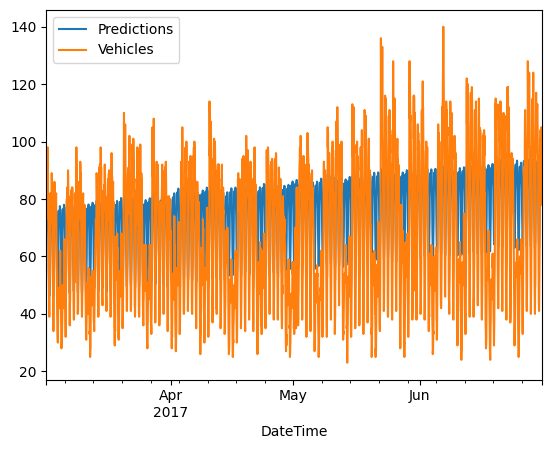

In [ ]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2015-11-01',end='2017-06-30')

pred=model.predict(exog = test[c], start=start,end=end,typ='levels').rename('ARIMA predictions')
preds= pd.DataFrame(columns=['DateTime', 'Predictions'])
preds.Predictions = pred
test_index= test.reset_index()
test_index = test_index['DateTime']
preds.DateTime= list (test_index)
preds.set_index('DateTime', inplace=True, drop=True)
#pred.index=list (test_index)
preds.plot(legend=True)
test['Vehicles'].plot(legend=True)

In [ ]:
test_index

0      2017-03-01 10:00:00
1      2017-03-01 11:00:00
2      2017-03-01 12:00:00
3      2017-03-01 13:00:00
4      2017-03-01 14:00:00
               ...        
2913   2017-06-30 19:00:00
2914   2017-06-30 20:00:00
2915   2017-06-30 21:00:00
2916   2017-06-30 22:00:00
2917   2017-06-30 23:00:00
Name: DateTime, Length: 2918, dtype: datetime64[ns]

In [ ]:
ARIMA_RMSE= mean_squared_error(test['Vehicles'], pred, squared=False)
ARIMA_MAPE= mean_absolute_percentage_error(test['Vehicles'], pred)*100
print("RMSE of ARIMAX:", ARIMA_RMSE)
print("MAPE of ARIMAX:", ARIMA_MAPE)

RMSE of ARIMAX: 18.093013937148424
MAPE of ARIMAX: 28.663573498687615


In [ ]:
model_performance = pd.DataFrame({
    "Model": ["LinearRegression","Lasso", "Ridge","CatBoost", "RandomForest", "DecisionTree", "SVR", "LinearSVR",
              "AdaBoost", "GradientBoosting", "LGBM", "XGBoost", 'Prophet', 'ARIMAX'],

    "RMSE": [lg_RMSE, l_RMSE, rr_RMSE,
              cat_RMSE, rf_RMSE, dt_RMSE, svc_RMSE, lsvc_RMSE, ab_RMSE, nb_RMSE, lgb_RMSE, xg_RMSE, prof_RMSE, ARIMA_RMSE],
    'MAPE': [lg_MAPE, l_MAPE, rr_MAPE,
              cat_MAPE, rf_MAPE, dt_MAPE, svc_MAPE, lsvc_MAPE, ab_MAPE, nb_MAPE, lgb_MAPE, xg_MAPE, prof_MAPE, ARIMA_MAPE]
    })

model_performance['Average Score']= (model_performance['RMSE']+model_performance['MAPE'])/2

model_performance = model_performance.sort_values(['Average Score'])

display(model_performance)

,Model,RMSE,MAPE,Average Score
10,LGBM,7.026064,7.906487,7.466276
4,RandomForest,7.125011,7.816291,7.470651
11,XGBoost,7.750239,8.533399,8.141819
9,GradientBoosting,7.646782,8.762928,8.204855
5,DecisionTree,9.990829,10.175633,10.083231
8,AdaBoost,9.964530,13.442490,11.703510
12,Prophet,13.210870,14.267848,13.739359
0,LinearRegression,12.854840,15.230172,14.042506
2,Ridge,12.695813,15.475677,14.085745
1,Lasso,12.790993,17.673074,15.232033


## Choosing Final model and Hyper Tuning

In [ ]:
#Train Test Split using 20% as test size
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# LGBM
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]
lgb = LGBMRegressor(num_iterations=510, learning_rate= 0.07007)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred) * 100
lgb_MAE= mean_absolute_error(y_valid,lgb_pred)
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE)
print('--------'*20)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 37
[LightGBM] [Info] Start training from score 39.523128
Average:  6.621947263547029
LGBM RMSE score on validation set is :  6.112860217926764
LGBM MAPE score on validation set is :  7.131034309167294
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
cat_viz= pd.DataFrame({'Feature':X.columns, 'Importance':lgb.feature_importances_}).sort_values(by="Importance",ascending=False)
cat_viz

,Feature,Importance
6,Time,2354
0,DateTime,1637
29,Time_std_vehicles,1208
34,day_of_year_std_vehicles,1198
37,day_of_year_mean_vehicles,864
35,day_of_year_max_vehicles,841
4,day_of_week,837
3,day_of_month,692
8,day_of_year,632
19,day_of_month_std_vehicles,575


In [ ]:
useless_cols1 = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])
X1= X.drop(useless_cols1,axis=1).reset_index(drop=True)
X_train=X1.iloc[:a]
y_train= y.iloc[:a]
X_valid=X1.iloc[a:]
y_valid=y.iloc[a:]
#Train Test Split using 20% as test size
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# LGBM
#400
lgb = LGBMRegressor(num_iterations=510, learning_rate= 0.07007)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred) *100
lgb_MAE= mean_absolute_error(y_valid,lgb_pred)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE)
print("LGBM MAE score on validation set is : ",lgb_MAE)
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print('--------'*20)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1763
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 33
[LightGBM] [Info] Start training from score 39.523128
LGBM RMSE score on validation set is :  6.112860217926764
LGBM MAPE score on validation set is :  7.131034309167294
LGBM MAE score on validation set is :  4.60665376811428
Average:  6.621947263547029
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
preds = cross_validation(X1 ,y , model = LGBMRegressor(num_iterations=510, learning_rate= 0.07007))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1332, number of used features: 29
[LightGBM] [Info] Start training from score 20.731982
Splits Trained: 0 	 RMSE:  7.875527160979963  	 MAPE: 24.100262470472956  	 MAE: 6.478404850692845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 32
[LightGBM] [Info] Start training from score 23.072235
Splits Trained: 1 	 RMSE:  4.355567392888789  	 MAPE: 11.074684820091374  	 MAE: 3.2476190

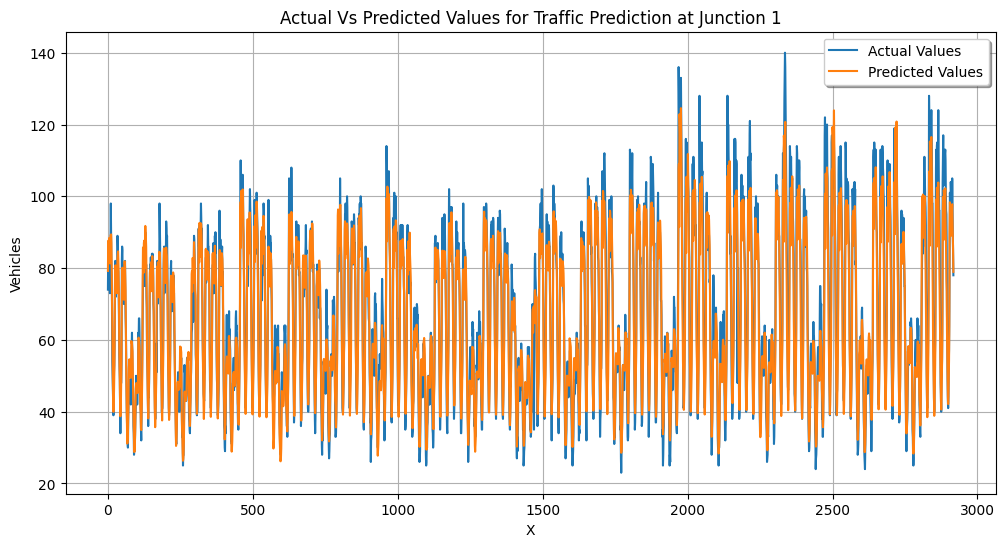

In [ ]:
import matplotlib.pyplot as plt
# visualizing in a plot
x_ax = range(len(y_valid))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_valid, label="Actual Values")
plt.plot(x_ax, lgb_pred, label="Predicted Values")
plt.title("Actual Vs Predicted Values for Traffic Prediction at Junction 1")
plt.xlabel('X')
plt.ylabel('Vehicles')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [ ]:
import pickle
pickle_out = open("junction1_model.pkl","wb")
pickle.dump(lgb, pickle_out)
pickle_out.close()